In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf
import tensorflow.contrib.learn as learn
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone
import pytz
import math

# Load transcripts

In [5]:
est_tz = pytz.timezone('US/Eastern')
def utc_to_est(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(est_tz)
    return est_tz.normalize(local_dt)

In [6]:
def shift_time_according_to_closing_time(dt):
    if dt.hour >= 16:
        return dt + timedelta(days=1)
    return dt

In [7]:
def load_and_clean_transcripts():
    client = MongoClient('localhost', 27017)
    earnings_transcript_collection = client.python_import.earnings_transcript
    
    earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find()))
    earnings_transcript.drop('_id', axis=1, inplace=True)
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ'), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: utc_to_est(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: shift_time_according_to_closing_time(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['publishDate_str'] = earnings_transcript.apply(
        lambda row: str(row['shifted_publishDate'].date()), axis=1
    )
    earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
    
    return earnings_transcript

In [8]:
earnings_transcript = load_and_clean_transcripts()

In [9]:
earnings_transcript.head(2)

,,publishDate,qAndAText,rawText,url,shifted_publishDate
tradingSymbol,publishDate_str,,,,,
A,2014-11-18,2014-11-17T22:25:00Z,,The following audio is from a conference call ...,https://seekingalpha.com/article/2675895-agile...,2014-11-18 17:25:00-05:00
AA,2014-10-09,2014-10-09T01:18:03Z,Operator [Operator instructions.] Our first qu...,Alcoa (NYSE: AA ) Q3 2014 Results Earnings Con...,https://seekingalpha.com/article/2549515-alcoa...,2014-10-09 21:18:03-04:00


In [10]:
earnings_transcript.tail(2)

publishDate  \
tradingSymbol publishDate_str                         
AET           2008-11-11       2008-11-11T03:27:16Z   
              2009-02-10       2009-02-10T20:01:09Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
AET           2008-11-11                                                           
              2009-02-10       Operator (Operator instructions)  Our first qu...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
AET           2008-11-11       Coventry Health Care, Inc. (CVH) Q3 FY08 Earni...   
              2009-02-10       Coventry Health Care, Inc., (CVH) Q4 2008 Earn...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
AET           2008-11-11       https://seekingalpha.com/article/105221-covent...   
              2009-02-10       https://seekingalpha.com/article/119714-covent...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
AET           2008-11-11      2008-11-11 22:27:16-05:00  
              2009-02-10      2009-02-10 15:01:09-05:00

### Load all ticker data for transcripts

In [11]:
earnings_transcript.index.levels[0]

Index(['A', 'AA', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABAX', 'ABBV',
       'ABC', 'ABCB', 'ABG', 'ABM', 'ABT', 'ACAT', 'ACC', 'ACE', 'ACET',
       'ACIW', 'ACM', 'ACN', 'ACOR', 'ACT', 'ACXM', 'ADBE', 'ADC', 'ADI',
       'ADM', 'ADNT', 'ADP', 'ADPT', 'ADS', 'ADSK', 'ADTN', 'AEE', 'AEGN',
       'AEIS', 'AEL', 'AEO', 'AEP', 'AES', 'AET'],
      dtype='object', name='tradingSymbol')

In [12]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        df['1day return normalized'] = df['1day return'] / df['Close']
        df['5day return normalized'] = df['5day return'] / df['Close']

In [13]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
for ticker in tickers:
    stock = []
    try:
        stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    except:
        print('{} is not available on Yahoo'.format(ticker))
        continue
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} does not have close prices'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)

A ticker has 4342 long list
AA ticker has 4342 long list
AAN ticker has 4342 long list
AAON ticker has 4342 long list
AAP ticker has 3864 long list
AAPL ticker has 4342 long list
AAT ticker has 1567 long list
AAWW ticker has 2870 long list
ABAX ticker has 4342 long list
ABBV ticker has 1073 long list
ABC ticker has 4342 long list
ABCB ticker has 4342 long list
ABG ticker has 3788 long list
ABM ticker has 4342 long list
ABT ticker has 4342 long list
ACAT ticker has 4320 long list
ACC ticker has 3183 long list
ACE is not available on Yahoo
ACET ticker has 4342 long list
ACIW ticker has 4342 long list
ACM ticker has 2495 long list
ACN ticker has 3953 long list
ACOR ticker has 2807 long list
ACT is not available on Yahoo
ACXM ticker has 4342 long list
ADBE ticker has 4342 long list
ADC ticker has 4342 long list
ADI ticker has 4342 long list
ADM ticker has 4342 long list
ADNT ticker has 117 long list
ADP ticker has 4342 long list
ADPT ticker has 701 long list
ADS ticker has 3976 long list
A

In [14]:
all_stocks.sample(20)

,,Close,Std Dev,1day return,5day return,1day return normalized,5day return normalized
tradingSymbol,publishDate_str,,,,,,
ABG,2010-11-01,14.570000,0.227903,0.330000,1.440000,0.022649,0.098833
AEL,2011-05-06,12.053184,0.249481,-0.065967,0.141358,-0.005473,0.011728
ACXM,2010-02-04,15.960000,0.798315,0.060000,-0.240000,0.003759,-0.015038
ACC,2012-10-25,37.727686,0.488196,0.647977,1.790465,0.017175,0.047458
ADS,2015-02-03,293.854447,6.241829,-2.945701,-15.763524,-0.010024,-0.053644
AAWW,2013-10-08,43.240002,1.259700,-0.040001,0.789997,-0.000925,0.018270
ACC,2007-06-27,18.771702,0.444209,0.020077,0.803068,0.001070,0.042781
ABAX,2007-10-01,21.556296,0.870829,1.013410,2.415137,0.047012,0.112039
ADC,2006-03-03,14.423627,0.335771,-0.107639,-0.065520,-0.007463,-0.004543


# Merge transcripts with stock data

In [15]:
merged_data = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [16]:
merged_data.sample(5)

,,publishDate,qAndAText,rawText,url,shifted_publishDate,Close,Std Dev,1day return,5day return,1day return normalized,5day return normalized
tradingSymbol,publishDate_str,,,,,,,,,,,
ADBE,2010-12-21,2010-12-21T07:41:20Z,Operator (Operator instructions) And our first...,Adobe Systems Incorporated (NASDAQ: ADBE ) F4Q...,https://seekingalpha.com/article/242895-adobe-...,2010-12-21 02:41:20-05:00,30.930000,0.714171,-0.280000,0.039999,-0.009053,0.001293
ABM,2016-03-09,2016-03-09T13:55:00Z,,The following audio is from a conference call ...,https://seekingalpha.com/article/3951546-abm-i...,2016-03-09 08:55:00-05:00,31.154969,0.626213,-0.762980,-0.567344,-0.024490,-0.018210
ADP,2016-07-29,2016-07-29T05:45:19Z,Operator [Operator Instructions]. We will take...,"Automatic Data Processing, Inc. (NASDAQ: ADP )...",https://seekingalpha.com/article/3993064-autom...,2016-07-29 01:45:19-04:00,87.419824,1.597839,-0.275182,0.707616,-0.003148,0.008094
ACIW,2014-05-01,2014-05-01T19:30:00Z,Operator [Operator Instructions] Your first qu...,ACI Worldwide (NASDAQ: ACIW ) Q1 2014 Earnings...,https://seekingalpha.com/article/2189493-aci-w...,2014-05-01 15:30:00-04:00,18.670000,0.377937,-0.020000,-1.053333,-0.001071,-0.056418
ACOR,2016-04-28,2016-04-28T16:27:25Z,Operator [Operator Instructions] Our first qu...,Acorda Therapeutics Inc (NASDAQ: ACOR ) Q1 201...,https://seekingalpha.com/article/3968839-acord...,2016-04-28 12:27:25-04:00,27.340000,1.116439,-1.490000,-1.700001,-0.054499,-0.062180


In [17]:
merged_data = merged_data[merged_data['rawText'].apply(len) > 5000]

# Create train data and test data

In [18]:
X = merged_data['rawText']
y = merged_data['5day return normalized'] * 100

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and DNN model

In [20]:
tfidf = TfidfVectorizer(max_df=0.33, min_df=3, ngram_range=(1,3), stop_words='english')

In [21]:
tfidf_vectors = tfidf.fit_transform(X_train)

In [22]:
classifier = learn.(hidden_units=[80, 40, 40],
                                feature_columns=[tf.contrib.layers.real_valued_column("", dimension=tfidf_vectors.shape[1])]
                               )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_environment': 'local', '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023B4DC97C50>, '_task_type': None, '_tf_random_seed': None, '_master': '', '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_task_id': 0}


In [23]:
classifier.fit(tfidf_vectors.todense(), y_train, batch_size=20, steps=500)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\neural\AppData\Local\Temp\tmpdiji7z2i\model.ckpt.
INFO:tensorflow:loss = 34.012, step = 1
INFO:tensorflow:global_step/sec: 3.60005
INFO:tensorflow:loss = 13.745, step = 101
INFO:tensorflow:global_step/sec: 3.76887
INFO:tensorflow:loss = 14.758, step = 201
INFO:tensorflow:global_step/sec: 3.86349
INFO:tensorflow:loss = 2.62698, step = 301
INFO:tensorflow:global_step/sec: 3.82987
INFO:tensorflow:loss = 0.294491, step = 401
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\neural\AppData\Local\Temp\tmpdiji7z2i\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00785149.


DNNRegressor(params={'hidden_units': [80, 40, 40], 'input_layer_min_slice_size': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x0000023B4A323840>, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x0000023B5C16F710>, 'embedding_lr_multipliers': None, 'feature_columns': (_RealValuedColumn(column_name='', dimension=318390, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'dropout': None})

In [24]:
y_predicted = list(classifier.predict(tfidf.transform(X_test).todense()))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


In [25]:
error = y_predicted - y_test

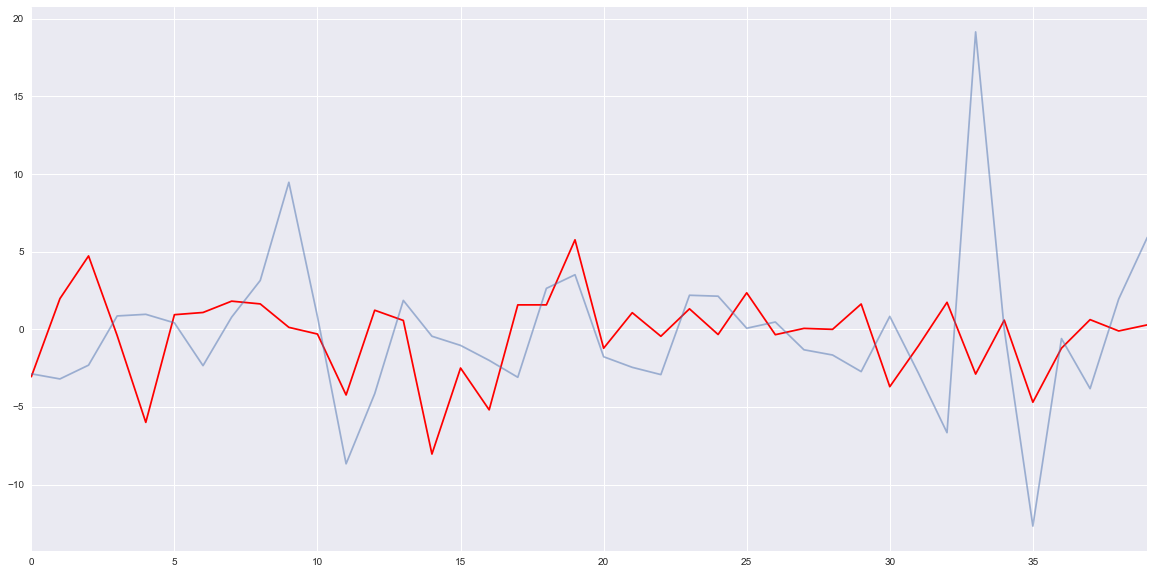

In [26]:
plt.figure(figsize=(20,10))
sns.tsplot(y_predicted[70:110], color='r')
sns.tsplot(y_test[70:110], alpha=0.5)
#sns.tsplot(error, alpha=0.2, color='g')

In [27]:
opposite = y_predicted * y_test

In [28]:
total_fail = opposite[opposite < 0]
total_success = opposite[opposite > 0]

In [29]:
len(total_fail)

181

In [30]:
len(total_success)

199

In [33]:
mean_squared_error(y_test, y_predicted)/100

0.36006484047171311